<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Открыли и прочитали файл, преобразовали формат в datetime64 аргументом parse_dates=[0], аргументом index_col установили индекс.

In [3]:
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Видим, что шаг в файле равен 10 минутам, по условиям проекта у нас 1 час ('1H').
Отсортируем индексы и проведем ресемплирование, установим шаг в 1 час. Так как нам нужно суммарные заказы за час, то применим к resample способ sum().

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

Проверим правильно ли отсортирован индекс

In [5]:
data.index.is_monotonic              

True

Проверяем, что шаг равен 1 часу

In [6]:
display(data.head(10))                   

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


В нашей таблице 4416 строк, временной интервал с 1 марта 2018 года по 31 августа 2018 года.

Проверим правильность наименования столбцов

In [8]:
print("Наименование столбцов:", data.columns)            

Наименование столбцов: Index(['num_orders'], dtype='object')


Название столбцов корректное

In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Видим, что среднее число заказов за час 84, максимальное 462, а минимальное 0.

Посмотрим процентное соотношение пропущенных значений:

In [10]:
pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
num_orders,0


Пропущенных значений нет, и не удивительно, ведь наше число мы получили из 6-ти исходных, так как провели ресемплирование из исходного значения 10 минут в 1 час (60 минут).

Посмотрим есть ли дубликаты:

In [11]:
data.duplicated().sum()                         

4165

В нашей ситуации, когда у нас один числовой столбец, наличие дубликатов очевидно, как не повторяться количеству заказов за 1 час. Трогать их не будем.

Посмотрим на графике наш файл.

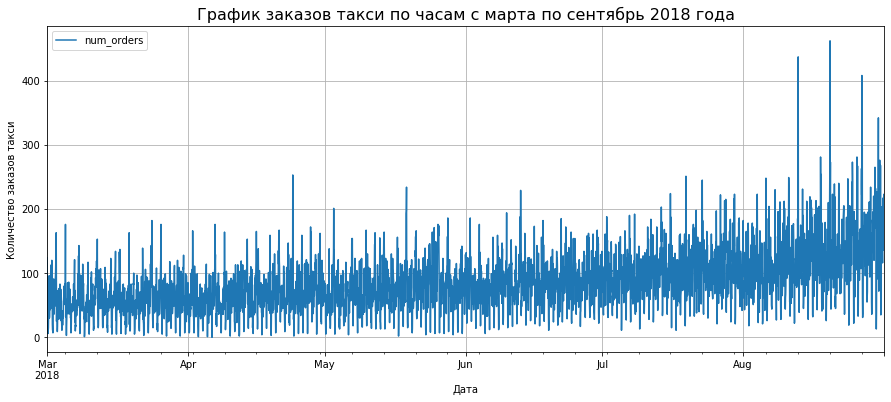

In [12]:
data.plot(figsize = (15,6), grid = True)
plt.title('График заказов такси по часам с марта по сентябрь 2018 года', size=16)
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси');

График по числу заказов такси

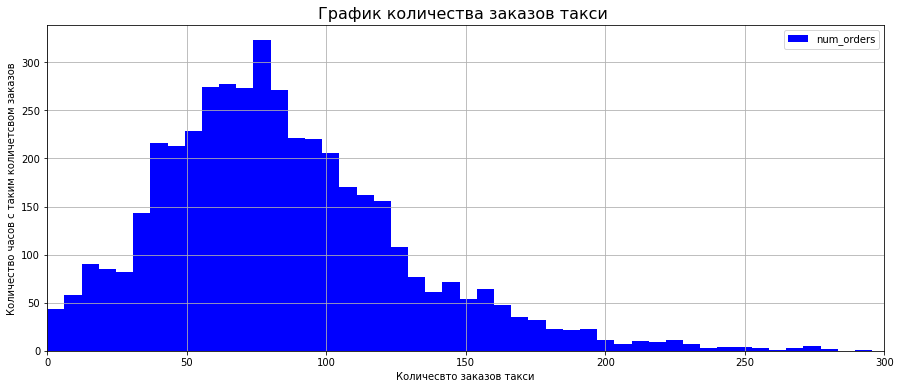

In [13]:
data.plot(kind= 'hist', bins = 75, grid = True, figsize = (15,6), xlim = (0,300), color ='b')
plt.title('График количества заказов такси ', size=16)
plt.xlabel('Количесвто заказов такси')
plt.ylabel('Количество часов с таким количетсвом заказов');

### Вывод

В этой части проекта сделано:
- открыт и прочитан файл, в нем содержаться история количества заказов такси с 1 марта 2018 года по 31 августа 2018 года
- при прочтении файла указан тип данных и установлен индекс,
- проведено ресемплирование, установлен шаг в 1 час, 
- проверено правильность сортироваки индексов,
- нашли, что минимальное количество заказов в час 0, максимальное 462, среднее 84,
- построен график заказов

## Анализ

По предыдущему графику не совсем наглядно видно изменения в граифке.
Чтобы снизить колебания, применим скользящее среднее и посмотрим на график.

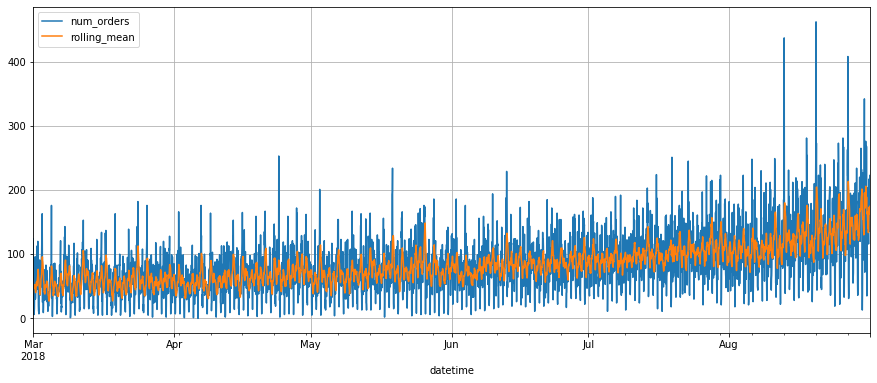

In [14]:
data['rolling_mean'] = data.rolling(10).mean() 
data.plot(figsize = (15,6), grid = True);

Видим с конца апреля устойчивый рост заказов, возможно это связанно с началом отпусков и теплого сезона, когда люди становятся более подвижны и активны.

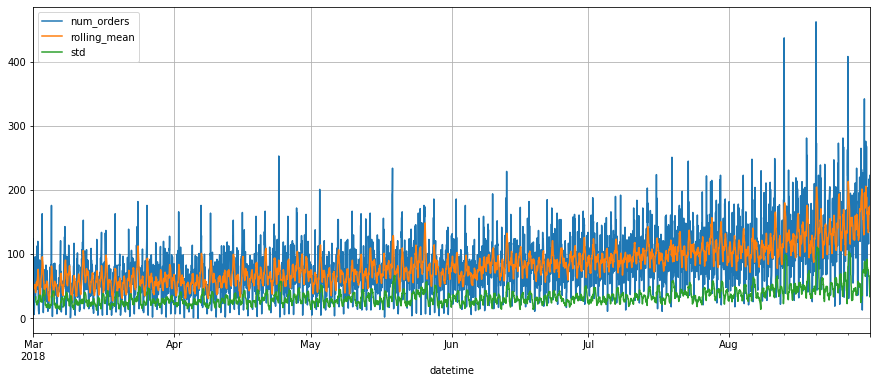

In [15]:
data['std'] = data['num_orders'].rolling(15).std()
data.plot(figsize = (15,6), grid = True); 

Добавили на график стандартное отклонение по скользящему окну (красный цвет) и среднее. Видим, рост по всем параметрам.

Построим графики тренда и сезонности

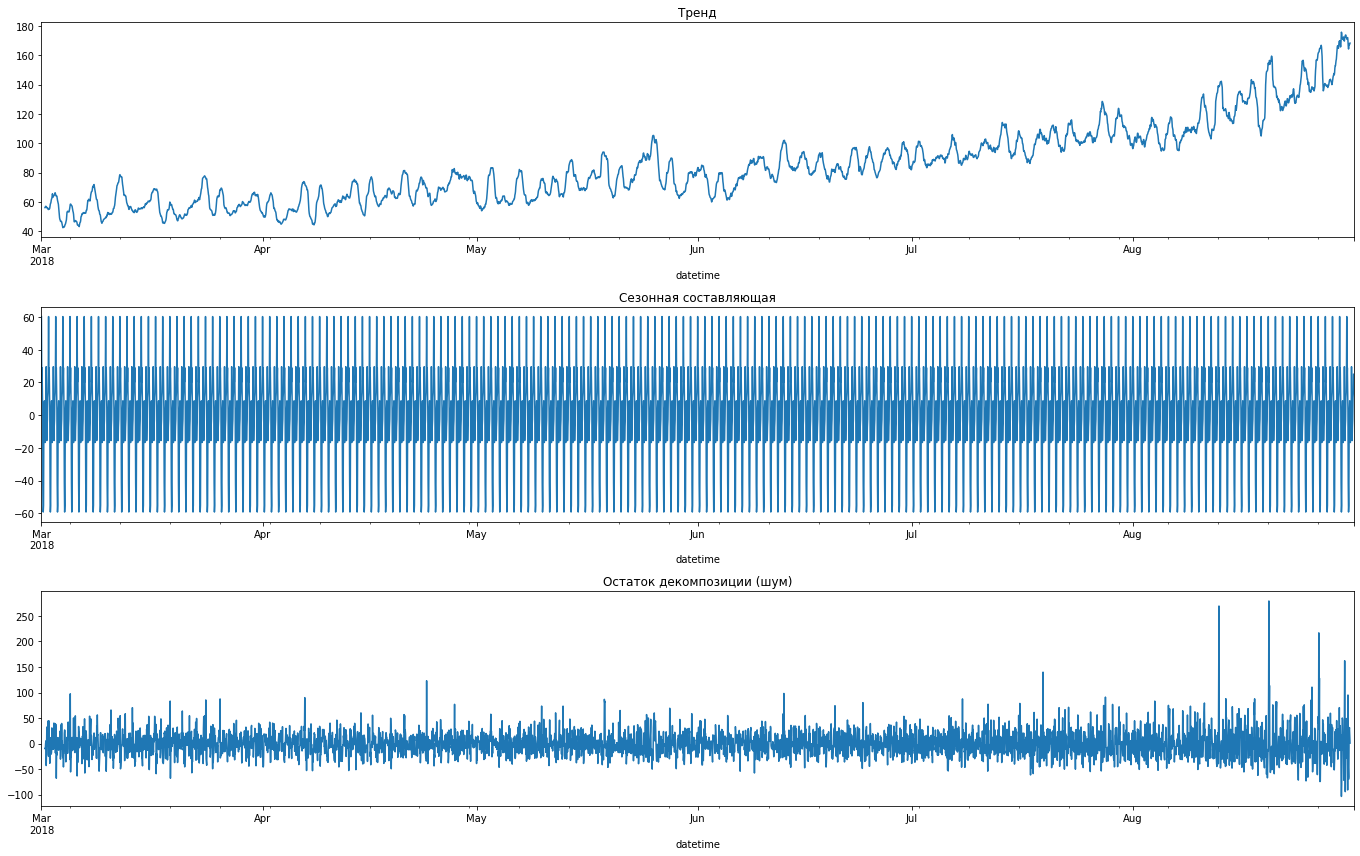

In [16]:
decomposed = seasonal_decompose(data['num_orders'], model='additive')

plt.figure(figsize=(19, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции (шум)')
plt.tight_layout()

Видим четкую сезонность. Чтобы лучше ее понять посмотрим месяц май по дням, а не по часам. Сделаем новый файл содержащий сведения за май с ресемплом 1 день.

In [17]:
data_may = data['2018-05-01':'2018-05-31'].resample('1D').sum()

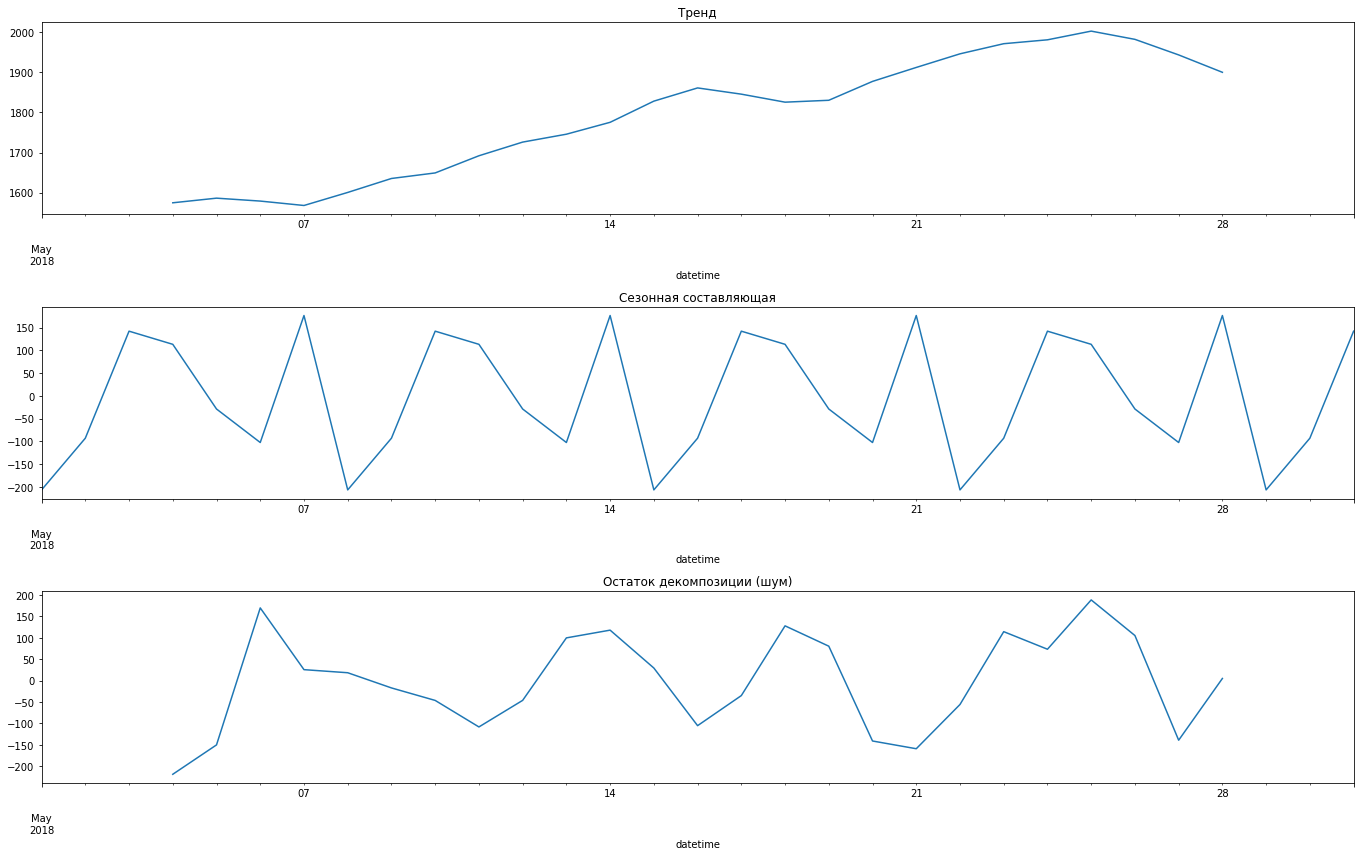

In [18]:
decomposed = seasonal_decompose(data_may['num_orders'], model='additive')

plt.figure(figsize=(19, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции (шум)')
plt.tight_layout()

Видим, что меньше всего заказов 8-го, 15-го, 22-го и 29-го мая 2018 года. Это вторники. По средам и воскресеньям количество заказов примерно равно.

Подготовим данные и посмотрим как в течение недели мая менялось количесвто заказов такси.

In [19]:
data_may_week = data['2018-05-14':'2018-05-21'].resample('2h').sum()

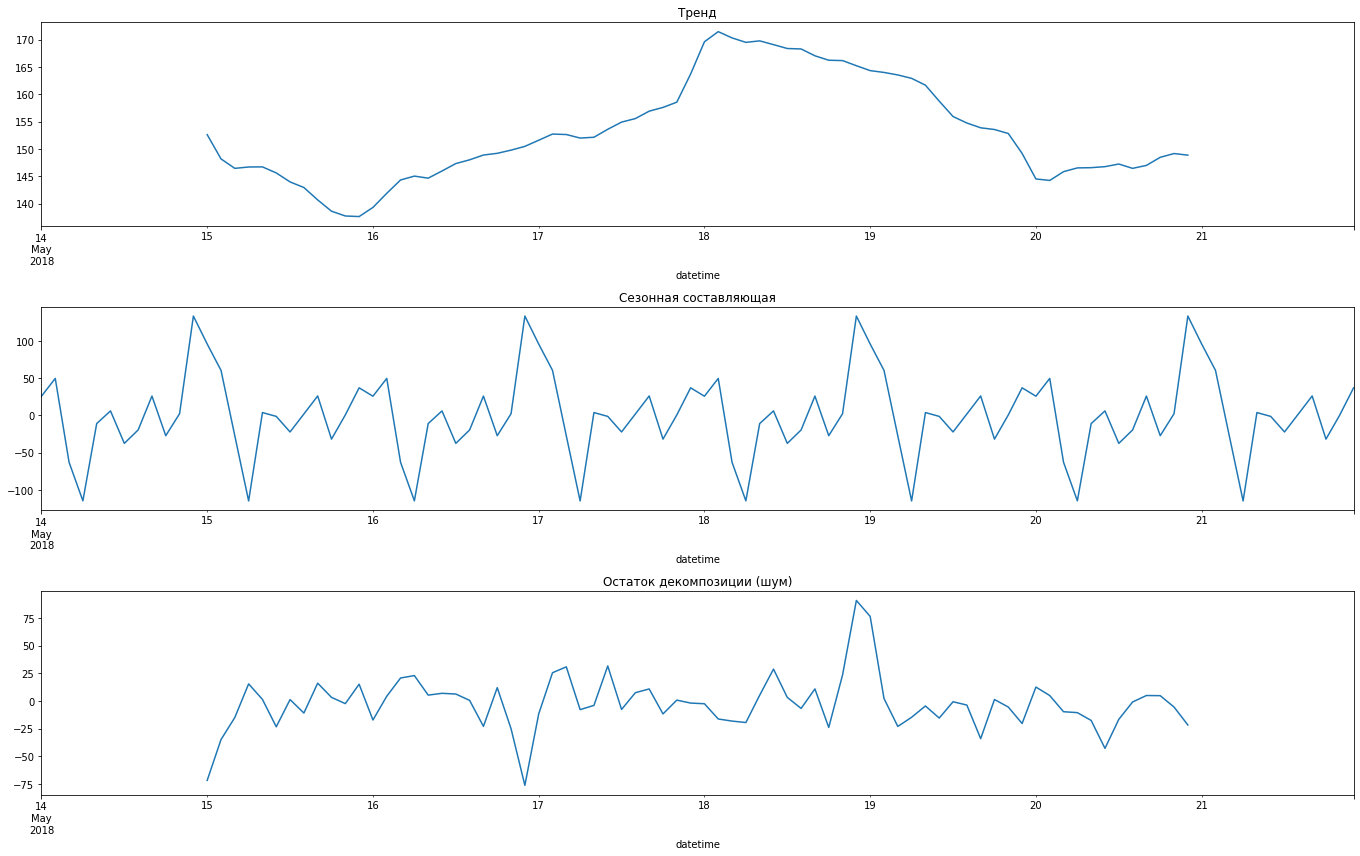

In [20]:
decomposed = seasonal_decompose(data_may_week['num_orders'], model='additive')

plt.figure(figsize=(19, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции (шум)')
plt.tight_layout()

Видим, что минимальное количесвто заказов приходится на 6 утра. Максимальное на 23 часа. Пик заказов приходится на вечером пятницы и ночь с пятницы на субботу.

Построим график на произвольную дат - 15 августа 2018 г.

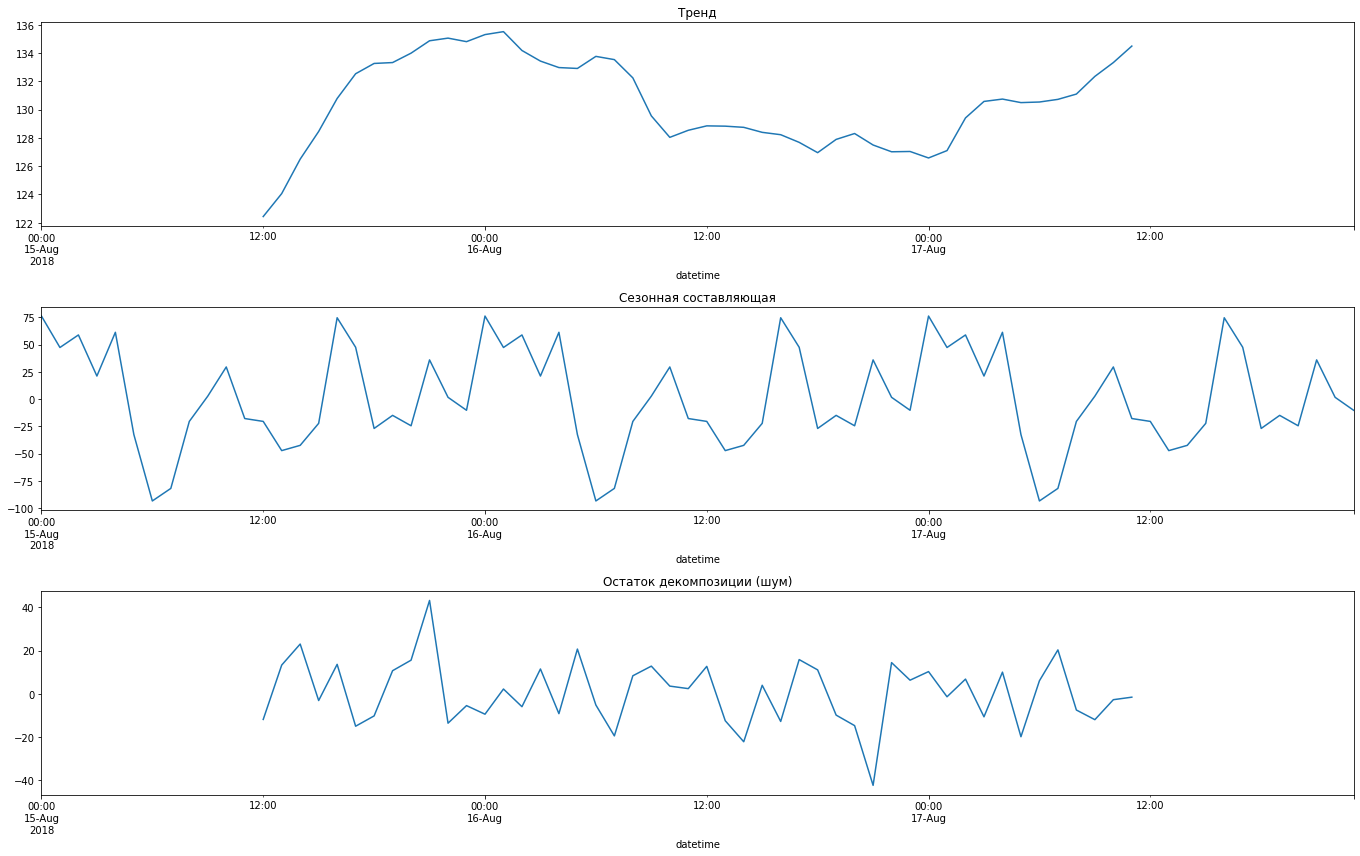

In [21]:
decomposed = seasonal_decompose(data['num_orders'].loc['2018-08-15':'2018-08-17'], model='additive')

plt.figure(figsize=(19, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции (шум)')
plt.tight_layout()

### Вывод

Построев графики увидели:
- устойчивый рост заказов с конца апреля
- минимальное количество заказов по вторникам
- максимальное количество заказов приходится на вечер пятницы и ночь с пятницы на субботу
- в течение дня минимальное количество заказов приходится на 6 утра
- ------------------- максимальное количество заказов приходится на промежуток с 20 до 24 часов

## Обучение

### Подготовка данных

Создадим признаки для горизонта прогнозирования

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [23]:
make_features(data, 2, 24)
display(data.head())

,num_orders,rolling_mean,std,dayofweek,hour,lag_1,lag_2
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,124.0,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,2,85.0,124.0
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0
2018-03-01 04:00:00,43,NaN,NaN,3,4,66.0,71.0


Разобьем на выборки, тестовая по условиям проекта будет размером 10%.

Функция train_test_split по умолчанию перемешивает данные, чтобы этого не произошло (ведь у нас предсказание) добавим параметр shuffle=False.

После применения функции make_features у нас появились NaN-значения за счет сдвига данных. Их не заполнить - удалим их.

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis = 1 )
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis =1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

Посмотрим размеры выборок

In [25]:
print("Train:", train.shape, '\n',
      "Valid:", valid.shape, '\n',
      "Test:", test.shape)

Train: (3950, 7) 
 Valid: (442, 7) 
 Test: (442, 7)


In [26]:
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

В качестве моделей будем использовать Линейную регрессию, CatBoost и LightGBM

### LinearRegression

In [27]:
%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
lr_pred = model_lr.predict(features_valid)
RMSE_lr = mean_squared_error(target_valid, lr_pred) ** .5
print('RMSE линейной регрессии {:.2f}'.format(RMSE_lr))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
RMSE линейной регрессии 51.32


### LightGBM

In [28]:
def to_lightgbm_par(features, target):
    model = LGBMRegressor()
    params = {
            'num_leaves': [7, 14, 31, 50],
            'learning_rate': [0.1, 0.003],
            'max_depth': [3, 5],
            'n_estimators': [50, 100],
    }
    split_index = TimeSeriesSplit()
    tscv = TimeSeriesSplit(n_splits=24) # (надо посмотерть, как подобрать параметр и аргументировать)<br>
    #gsearch = GridSearchCV(gbm, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1) 
    gsearch = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1) 
    gsearch.fit(features, target, verbose=30)
    print('Best hyperparams: ', gsearch.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-gsearch.best_score_) ** 0.5))
    return gsearch.best_params_

In [29]:
%%time

lifhtgbm_params = to_lightgbm_par(features_train, target_train)

Fitting 24 folds for each of 32 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 30.1min finished


Best hyperparams:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}
RMSE score on train sample: 22.62
CPU times: user 29min 37s, sys: 12.9 s, total: 29min 50s
Wall time: 30min 6s


In [30]:
%%time

lgbm_model = LGBMRegressor(**lifhtgbm_params)
lgbm_model.fit(features_train, target_train, verbose=20)

CPU times: user 694 ms, sys: 16.8 ms, total: 711 ms
Wall time: 697 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [31]:
%%time

lgbm_pred = lgbm_model.predict(features_valid)

RMSE_CBR = mean_squared_error(target_valid, lgbm_pred) ** .5
print('RMSE LGBMRegressor: {:.2f}'.format(RMSE_CBR))

RMSE LGBMRegressor: 43.17
CPU times: user 35.4 ms, sys: 4.05 ms, total: 39.4 ms
Wall time: 88.5 ms


### CatBoostRegressor

In [32]:
def to_catboost_par(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [15, 45],
            'verbose' : [0],
            'max_depth' : [5, 10]
    }


    split_index = TimeSeriesSplit()
    tscv = TimeSeriesSplit(n_splits=24) # (надо посмотерть, как подобрать параметр и аргументировать)<br>
    #gsearch = GridSearchCV(gbm, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1) 
    gsearch = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1) 
    
    
    
    #grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=1, scoring='neg_mean_squared_error')
    gsearch.fit(features, target, verbose=30)
    print('Best hyperparams: ', gsearch.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-gsearch.best_score_) ** 0.5))
    return gsearch.best_params_

In [33]:
%%time

catb_params = to_catboost_par(features_train, target_train)

Fitting 24 folds for each of 4 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 29.8988154	total: 47.7ms	remaining: 667ms
14:	learn: 26.2732527	total: 54ms	remaining: 0us
0:	learn: 28.7169720	total: 1.69ms	remaining: 23.7ms
14:	learn: 24.8858237	total: 45.9ms	remaining: 0us
0:	learn: 28.4718703	total: 1.08ms	remaining: 15.1ms
14:	learn: 24.0392575	total: 41.1ms	remaining: 0us
0:	learn: 29.5089051	total: 1.45ms	remaining: 20.3ms
14:	learn: 24.8815855	total: 11.3ms	remaining: 0us
0:	learn: 29.1282353	total: 1.09ms	remaining: 15.2ms
14:	learn: 24.8163267	total: 89.3ms	remaining: 0us
0:	learn: 29.1161695	total: 1.94ms	remaining: 27.1ms
14:	learn: 24.8483204	total: 72.2ms	remaining: 0us
0:	learn: 29.2779397	total: 1.68ms	remaining: 23.5ms
14:	learn: 25.1187864	total: 165ms	remaining: 0us
0:	learn: 29.6566522	total: 1.79ms	remaining: 25ms
14:	learn: 25.4200384	total: 127ms	remaining: 0us
0:	learn: 30.6724510	total: 2.33ms	remaining: 32.7ms
14:	learn: 26.5024370	total: 68ms	remaining: 0us
0:	learn: 30.5640340	total: 3.91ms	remaining: 54.7ms
14:	learn: 26.359320

[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  3.2min finished


0:	learn: 38.0674945	total: 13.9ms	remaining: 610ms
30:	learn: 27.4302690	total: 1.58s	remaining: 716ms
44:	learn: 25.1238660	total: 2.29s	remaining: 0us
Best hyperparams:  {'max_depth': 10, 'n_estimators': 45, 'verbose': 0}
RMSE score on train sample: 28.29
CPU times: user 1min 19s, sys: 12.7 s, total: 1min 32s
Wall time: 3min 15s


In [34]:
%%time

catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(features_train, target_train, verbose=20)

0:	learn: 38.0674945	total: 16.8ms	remaining: 739ms
20:	learn: 29.7567166	total: 1.06s	remaining: 1.22s
40:	learn: 25.6849187	total: 2.15s	remaining: 210ms
44:	learn: 25.1238660	total: 2.35s	remaining: 0us
CPU times: user 2.18 s, sys: 315 ms, total: 2.5 s
Wall time: 3.56 s


In [35]:
%%time

catb_pred = catb_model.predict(features_valid)

RMSE_CBR = mean_squared_error(target_valid, catb_pred) ** .5
print('RMSE CatBootsRegressor: {:.2f}'.format(RMSE_CBR))

RMSE CatBootsRegressor: 60.66
CPU times: user 3.33 ms, sys: 12.7 ms, total: 16 ms
Wall time: 10.7 ms


### Вывод

## Тестирование

LinearRegression

In [36]:
print('RMSE LinearRegression_valid: {:.2f}'.format(rmse(target_valid, lr_pred)))
print()
print('RMSE LinearRegression_test: {:.2f}'.format(rmse(target_test, lr_pred)))

RMSE LinearRegression_valid: 51.32

RMSE LinearRegression_test: 51.32


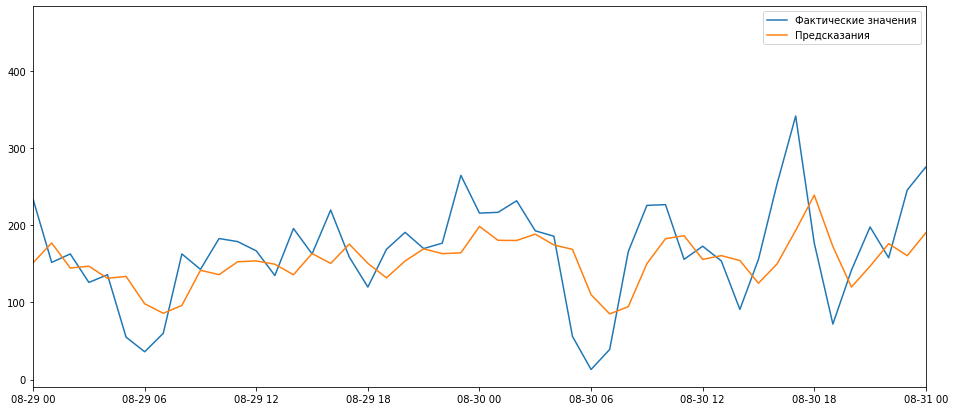

In [37]:
plt.figure(figsize=(16,7))
plt.plot(target_valid.index, target_valid, label='Фактические значения')
plt.plot(target_valid.index, lr_pred, label='Предсказания')
plt.legend()
plt.xlim(['2018-08-29','2018-08-31'])
plt.show()

LGBMRegressor

In [38]:
print('RMSE LGBMRegressor_valid: {:.2f}'.format(rmse(target_valid, lgbm_pred)))
print()
print('RMSE LGBMRegressor_test: {:.2f}'.format(rmse(target_test, lgbm_pred)))

RMSE LGBMRegressor_valid: 43.17

RMSE LGBMRegressor_test: 43.17


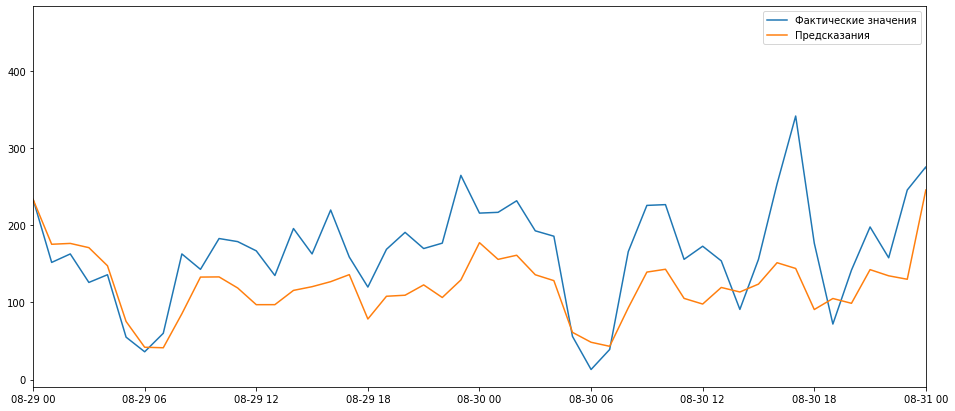

In [39]:
plt.figure(figsize=(16,7))
plt.plot(target_valid.index, target_valid, label='Фактические значения')
plt.plot(target_test.index, lgbm_pred, label='Предсказания')
plt.legend()
plt.xlim(['2018-08-29','2018-08-31'])
plt.show()

CatBoostRegressor

In [40]:
print('RMSE CatBoostRegressor_valid: {:.2f}'.format(rmse(target_valid, catb_pred)))
print()
print('RMSE CatBoostRegressor_test: {:.2f}'.format(rmse(target_test, catb_pred)))

RMSE CatBoostRegressor_valid: 60.66

RMSE CatBoostRegressor_test: 60.66


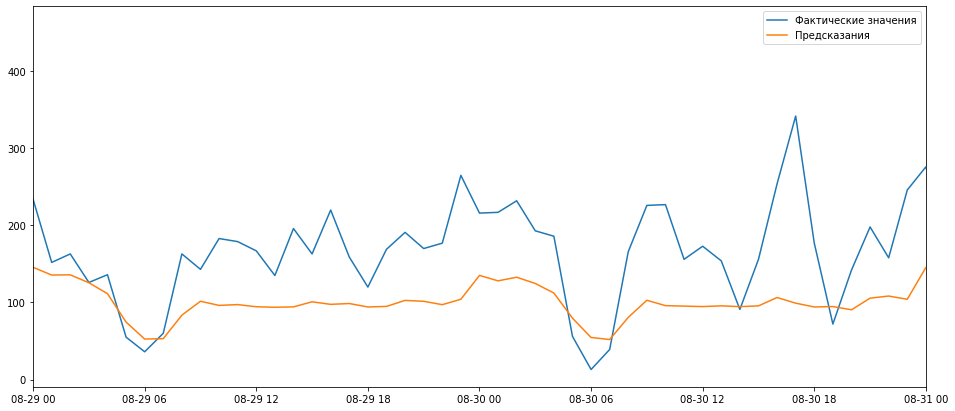

In [41]:
plt.figure(figsize=(16,7))
plt.plot(target_valid.index, target_valid, label='Фактические значения')
plt.plot(target_test.index, catb_pred, label='Предсказания')
plt.legend()
plt.xlim(['2018-08-29','2018-08-31'])
plt.show()

###  Вывод

Проверили наши выборки на тестовой выборке.
Значения RMSE на valid и test выборке полностью совпадают.

По условиям проекта, необходимо чтобы RMSE было не более 48, под это требование подходит модель LGBMRegressor с параметрами:
- learning_rate: 0.1, 
- max_depth: 5, 
- n_estimators: 100, 
- num_leaves: 7.

Задача проекта достигнута.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48